# Understanding Activation Functions with MLP on Fashion MNIST

## Code adapted from https://github.com/phlippe/uvadlc_notebooks/tree/master/docs/tutorial_notebooks/tutorial3

In [55]:
## Standard libraries
import os
import json
import math
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

/var/folders/2v/0s_wd0cd04g3xtcdpppg90980000gn/T/ipykernel_55401/3000458389.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [57]:
device = torch.device("mps") if torch.mps.is_available() else torch.device("cpu")
print("Using device", device)

Using device mps


In [79]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    if torch.mps.is_available():
        torch.mps.manual_seed(seed)

In [61]:
# Implement various activation functions

class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1/(1+torch.exp(-x))

class Tanh(ActivationFunction):
    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

class ReLU(ActivationFunction):
    def forward(self, x):
        return torch.where(x > 0, x, 0)

class LeakyReLU(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha
    def forward(self, x):
        return torch.where(x > 0, x, self.config['alpha']*x)

class ELU(ActivationFunction):
    def forward(self, x):
        return torch.where(x > 0, x, (torch.exp(x) - 1))

class Swish(ActivationFunction):
    def forward(self, x):
        return x*torch.sigmoid(x)

act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}

In [63]:
def get_grads(act_fn, x):
    x = x.clone().requires_grad_()
    y = act_fn(x).sum()
    y.backward()
    return x.grad

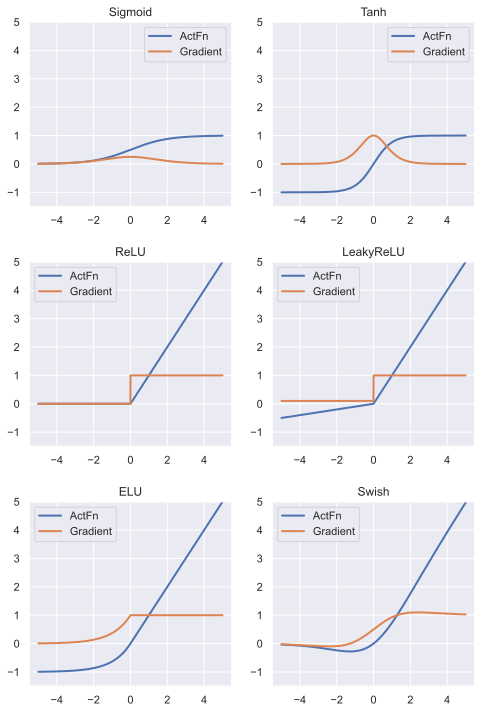

In [65]:
def vis_act_fn(act_fn, ax, x):
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000)
rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

In [67]:
class BaseNetwork(nn.Module): #MLP
    
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        super().__init__()
        
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers) 
        
        self.config = {"act_fn": act_fn.config, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes} 
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        logits = self.layers(x)
        return logits 

In [106]:
CHECKPOINT_PATH = "./saved_models"

def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, net=None):
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), "Could not find the config file \"%s\". Are you sure this is the correct path and you have your model config stored here?" % (config_file)
    assert os.path.isfile(model_file), "Could not find the model file \"%s\". Are you sure this is the correct path and you have your model stored here?" % (model_file)
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net
    
def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

In [71]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

DATASET_PATH = "../data"
# Transformations applied on each image => first make them a tensor, then normalize them in the range -1 to 1
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

100%|██████████| 26.4M/26.4M [00:26<00:00, 1.00MB/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|███████████| 29.5k/29.5k [00:00<00:00, 236kB/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 4.05MB/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 11.7MB/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



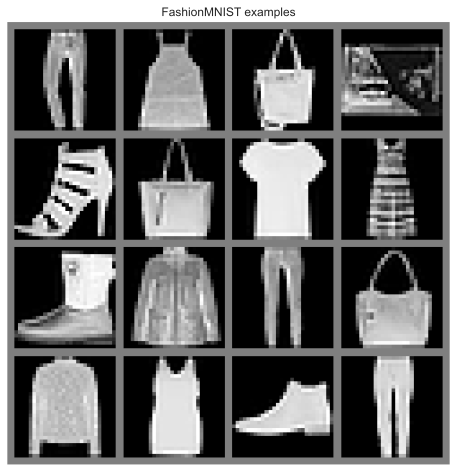

In [73]:
exmp_imgs = [train_set[i][0] for i in range(16)]
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [75]:
def visualize_gradients(net, color="C0"):
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    net.zero_grad()
    out = net(imgs)
    loss = F.cross_entropy(out, labels)
    loss.backward()
    
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()
    
    ## Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index%columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title("%s" % key)
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1
    fig.suptitle("Gradient magnitude distribution for activation function %s" % (net.config["act_fn"]["name"]), fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close() 

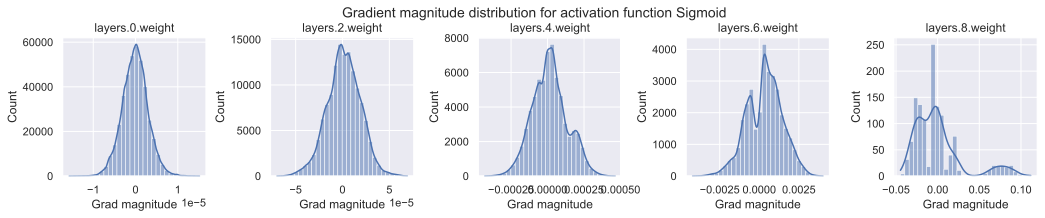

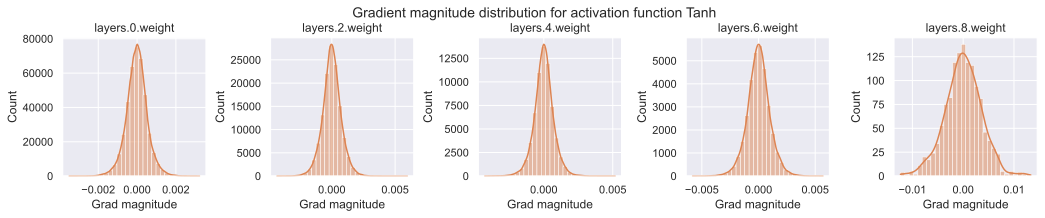

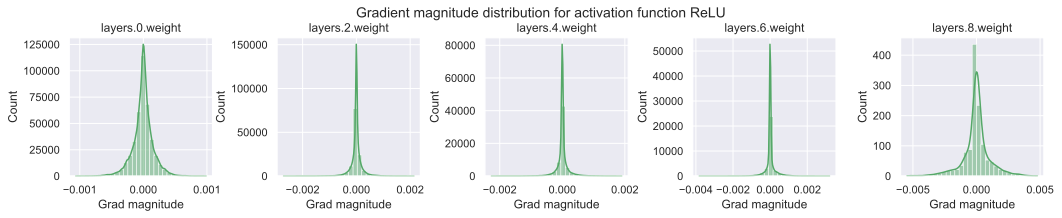

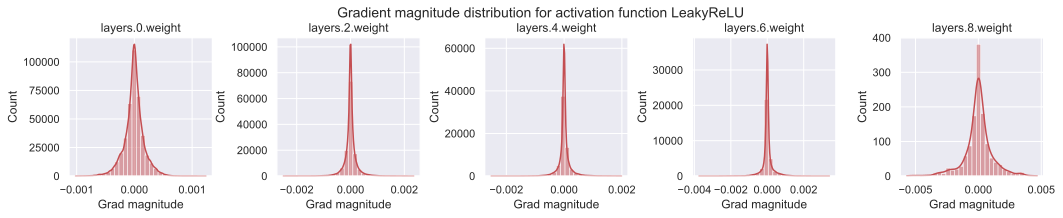

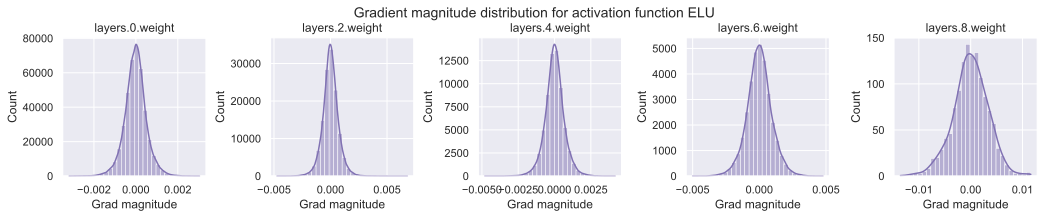

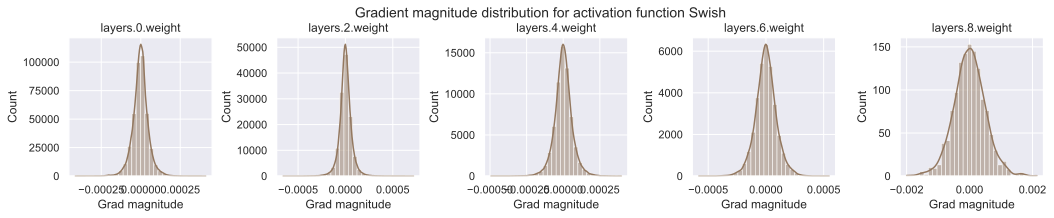

In [81]:
# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings
warnings.filterwarnings('ignore')
for i, act_fn_name in enumerate(act_fn_by_name):
    set_seed(42) # Setting the seed ensures that we have the same weight initialization for each activation function
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color="C%i"%i)

"The sigmoid activation function shows a clearly undesirable behavior. While the gradients for the output layer are very large with up to 0.1, the input layer has the lowest gradient norm across all activation functions with only 1e-5. This is due to its small maximum gradient of 1/4, and finding a suitable learning rate across all layers is not possible in this setup. All the other activation functions show to have similar gradient norms across all layers. Interestingly, the ReLU activation has a spike around 0 which is caused by its zero-part on the left, and dead neurons (we will take a closer look at this later on)."

In [108]:
def train_model(net, model_name, max_epochs=20, patience=7, batch_size=256):
    optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # Default parameters, feel free to change
    loss_module = nn.CrossEntropyLoss() 
    train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

    val_scores = []
    best_val_epoch = -1
    for epoch in range(max_epochs):
        net.train()
        true_preds, count = 0., 0
        for imgs, labels in tqdm(train_loader, desc="Epoch %i" % (epoch+1), leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = net(imgs)
            loss = loss_module(preds, labels)
            loss.backward()
            optimizer.step()
            true_preds += (preds.argmax(dim=-1) == labels).sum()
            count += labels.shape[0]
        train_acc = true_preds / count

        val_acc = test_model(net, val_loader)
        val_scores.append(val_acc)
        print("[Epoch %2i] Training accuracy: %05.2f%%, Validation accuracy: %05.2f%%" % (epoch+1, train_acc*100.0, val_acc*100.0))

        if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
            print("\t   (New best performance, saving model...)")
            save_model(net, CHECKPOINT_PATH, model_name)
            best_val_epoch = epoch
        elif best_val_epoch <= epoch - patience:
            print("Early stopping due to no improvement over the last %i epochs" % (patience))
            break

    plt.plot([i for i in range(1,len(val_scores)+1)], torch.tensor(val_scores).cpu().numpy())
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.title("Validation performance of %s" % model_name)
    plt.show()
    plt.close()
    
    test_acc = test_model(net, test_loader)
    print((" Test accuracy: %4.2f%% " % (test_acc*100.0)).center(50, "=")+"\n")
    return test_acc

def test_model(net, data_loader):
    net.eval()
    true_preds, count = 0., 0
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = net(imgs)
            true_preds += (preds.argmax(dim = 1) == labels).sum()
            count += imgs.shape[0]
    test_acc = true_preds / count
    return test_acc 

Training BaseNetwork with sigmoid activation...


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 10.12%, Validation accuracy: 10.08%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 09.99%, Validation accuracy: 09.94%


Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 09.83%, Validation accuracy: 09.91%


Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 10.14%, Validation accuracy: 10.08%


Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 10.10%, Validation accuracy: 10.49%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 09.96%, Validation accuracy: 10.49%


Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 09.88%, Validation accuracy: 09.91%


Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 09.96%, Validation accuracy: 09.91%


Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 10.08%, Validation accuracy: 09.59%


Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 10.03%, Validation accuracy: 10.06%


Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 10.09%, Validation accuracy: 09.62%


Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 09.97%, Validation accuracy: 09.91%
Early stopping due to no improvement over the last 7 epochs


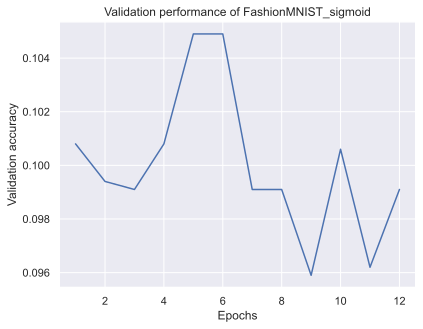

============= Test accuracy: 10.00% ==============

Training BaseNetwork with tanh activation...


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 48.66%, Validation accuracy: 62.91%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 67.46%, Validation accuracy: 72.77%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 74.00%, Validation accuracy: 76.86%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 77.37%, Validation accuracy: 79.32%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 80.22%, Validation accuracy: 81.19%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 81.72%, Validation accuracy: 82.63%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 82.61%, Validation accuracy: 82.59%


Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 83.46%, Validation accuracy: 83.54%
	   (New best performance, saving model...)


Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 84.16%, Validation accuracy: 84.71%
	   (New best performance, saving model...)


Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 84.55%, Validation accuracy: 85.21%
	   (New best performance, saving model...)


Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 85.04%, Validation accuracy: 85.66%
	   (New best performance, saving model...)


Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 85.34%, Validation accuracy: 85.76%
	   (New best performance, saving model...)


Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 85.53%, Validation accuracy: 85.64%


Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 85.74%, Validation accuracy: 86.14%
	   (New best performance, saving model...)


Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 86.03%, Validation accuracy: 86.06%


Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 86.19%, Validation accuracy: 86.25%
	   (New best performance, saving model...)


Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 86.50%, Validation accuracy: 86.22%


Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 86.74%, Validation accuracy: 86.58%
	   (New best performance, saving model...)


Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 86.84%, Validation accuracy: 86.40%


Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 87.20%, Validation accuracy: 86.91%
	   (New best performance, saving model...)


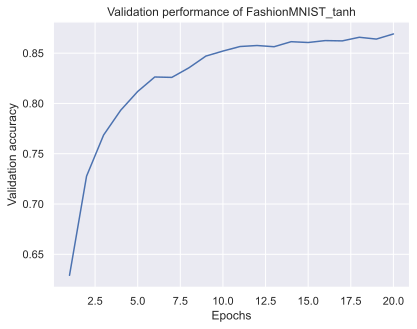

============= Test accuracy: 85.16% ==============

Training BaseNetwork with relu activation...


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 18.08%, Validation accuracy: 35.99%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 44.71%, Validation accuracy: 62.95%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 65.03%, Validation accuracy: 72.01%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 72.89%, Validation accuracy: 76.45%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 77.05%, Validation accuracy: 79.27%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 79.64%, Validation accuracy: 80.75%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 81.15%, Validation accuracy: 82.50%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 82.32%, Validation accuracy: 83.33%
	   (New best performance, saving model...)


Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 83.03%, Validation accuracy: 83.81%
	   (New best performance, saving model...)


Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 83.83%, Validation accuracy: 84.62%
	   (New best performance, saving model...)


Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 84.16%, Validation accuracy: 84.10%


Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 84.85%, Validation accuracy: 85.29%
	   (New best performance, saving model...)


Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 85.43%, Validation accuracy: 85.34%
	   (New best performance, saving model...)


Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 85.87%, Validation accuracy: 85.99%
	   (New best performance, saving model...)


Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 86.25%, Validation accuracy: 86.61%
	   (New best performance, saving model...)


Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 86.38%, Validation accuracy: 86.56%


Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 86.85%, Validation accuracy: 86.77%
	   (New best performance, saving model...)


Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 87.14%, Validation accuracy: 87.23%
	   (New best performance, saving model...)


Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 87.41%, Validation accuracy: 87.29%
	   (New best performance, saving model...)


Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 87.83%, Validation accuracy: 87.56%
	   (New best performance, saving model...)


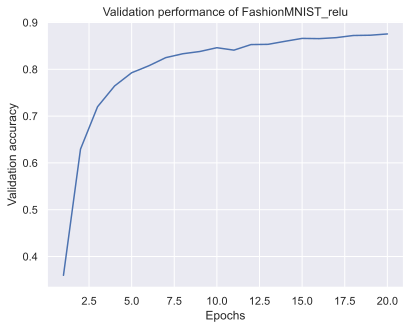

============= Test accuracy: 85.81% ==============

Training BaseNetwork with leakyrelu activation...


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 20.70%, Validation accuracy: 39.76%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 46.70%, Validation accuracy: 62.76%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 65.92%, Validation accuracy: 72.81%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 73.62%, Validation accuracy: 77.02%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 77.48%, Validation accuracy: 79.53%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 79.80%, Validation accuracy: 80.99%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 81.32%, Validation accuracy: 82.42%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 82.35%, Validation accuracy: 83.37%
	   (New best performance, saving model...)


Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 83.04%, Validation accuracy: 83.81%
	   (New best performance, saving model...)


Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 83.81%, Validation accuracy: 84.53%
	   (New best performance, saving model...)


Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 84.07%, Validation accuracy: 84.40%


Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 84.76%, Validation accuracy: 85.09%
	   (New best performance, saving model...)


Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 85.28%, Validation accuracy: 85.10%
	   (New best performance, saving model...)


Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 85.68%, Validation accuracy: 86.13%
	   (New best performance, saving model...)


Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 86.06%, Validation accuracy: 86.38%
	   (New best performance, saving model...)


Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 86.30%, Validation accuracy: 86.32%


Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 86.58%, Validation accuracy: 86.20%


Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 86.85%, Validation accuracy: 87.18%
	   (New best performance, saving model...)


Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 87.21%, Validation accuracy: 86.98%


Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 87.50%, Validation accuracy: 87.22%
	   (New best performance, saving model...)


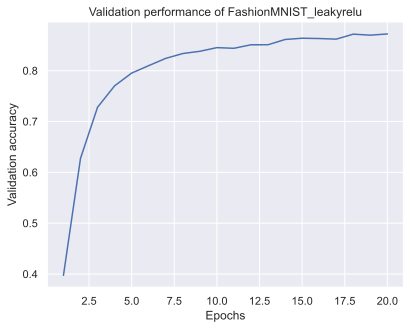

============= Test accuracy: 85.72% ==============

Training BaseNetwork with elu activation...


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 47.55%, Validation accuracy: 61.97%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 67.86%, Validation accuracy: 73.99%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 74.79%, Validation accuracy: 77.45%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 78.25%, Validation accuracy: 80.33%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 80.67%, Validation accuracy: 81.77%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 82.09%, Validation accuracy: 82.76%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 82.75%, Validation accuracy: 83.77%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 83.53%, Validation accuracy: 84.03%
	   (New best performance, saving model...)


Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 84.13%, Validation accuracy: 84.90%
	   (New best performance, saving model...)


Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 84.65%, Validation accuracy: 85.35%
	   (New best performance, saving model...)


Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 84.82%, Validation accuracy: 85.30%


Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 85.23%, Validation accuracy: 85.99%
	   (New best performance, saving model...)


Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 85.50%, Validation accuracy: 86.05%
	   (New best performance, saving model...)


Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 85.55%, Validation accuracy: 85.87%


Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 85.72%, Validation accuracy: 86.14%
	   (New best performance, saving model...)


Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 86.07%, Validation accuracy: 86.28%
	   (New best performance, saving model...)


Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 86.26%, Validation accuracy: 86.23%


Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 86.50%, Validation accuracy: 86.56%
	   (New best performance, saving model...)


Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 86.52%, Validation accuracy: 86.63%
	   (New best performance, saving model...)


Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 86.87%, Validation accuracy: 86.56%


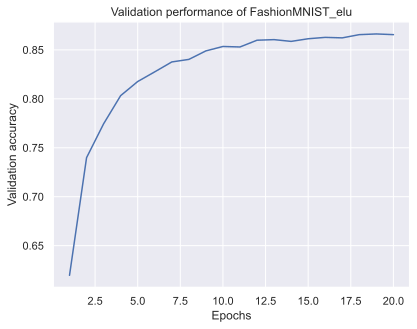

============= Test accuracy: 84.93% ==============

Training BaseNetwork with swish activation...


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 10.92%, Validation accuracy: 09.87%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 19.35%, Validation accuracy: 40.60%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 50.19%, Validation accuracy: 52.82%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 39.73%, Validation accuracy: 31.28%


Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 49.76%, Validation accuracy: 61.88%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 65.94%, Validation accuracy: 69.18%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 73.01%, Validation accuracy: 75.65%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 76.18%, Validation accuracy: 77.91%
	   (New best performance, saving model...)


Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 78.58%, Validation accuracy: 79.31%
	   (New best performance, saving model...)


Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 80.59%, Validation accuracy: 81.24%
	   (New best performance, saving model...)


Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 81.33%, Validation accuracy: 82.54%
	   (New best performance, saving model...)


Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 82.35%, Validation accuracy: 82.33%


Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 82.62%, Validation accuracy: 83.32%
	   (New best performance, saving model...)


Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 83.49%, Validation accuracy: 84.33%
	   (New best performance, saving model...)


Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 83.99%, Validation accuracy: 84.64%
	   (New best performance, saving model...)


Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 84.20%, Validation accuracy: 84.70%
	   (New best performance, saving model...)


Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 84.50%, Validation accuracy: 84.57%


Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 84.98%, Validation accuracy: 84.98%
	   (New best performance, saving model...)


Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 85.11%, Validation accuracy: 85.18%
	   (New best performance, saving model...)


Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 85.56%, Validation accuracy: 85.73%
	   (New best performance, saving model...)


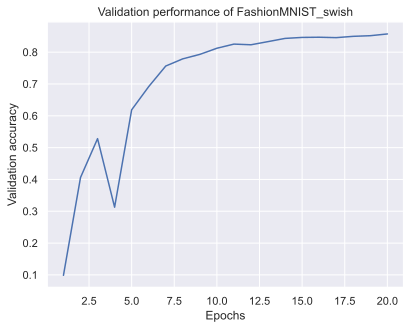

============= Test accuracy: 84.27% ==============



In [110]:
for act_fn_name in act_fn_by_name:
    print("Training BaseNetwork with %s activation..." % act_fn_name)
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, "FashionMNIST_%s" % act_fn_name)

"Not surprisingly, the model using the sigmoid activation function shows to fail and does not improve upon random performance (10 classes => 1/10 for random chance)."

In [111]:
def visualize_activations(net, color="C0"):
    activations = {}
    
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024)
    imgs, labels = next(iter(small_loader))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()
    
    ## Plotting
    columns = 4
    rows = math.ceil(len(activations)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index//columns][fig_index%columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title("Layer %i - %s" % (key, net.layers[key].__class__.__name__))
        fig_index += 1
    fig.suptitle("Activation distribution for activation function %s" % (net.config["act_fn"]["name"]), fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close() 

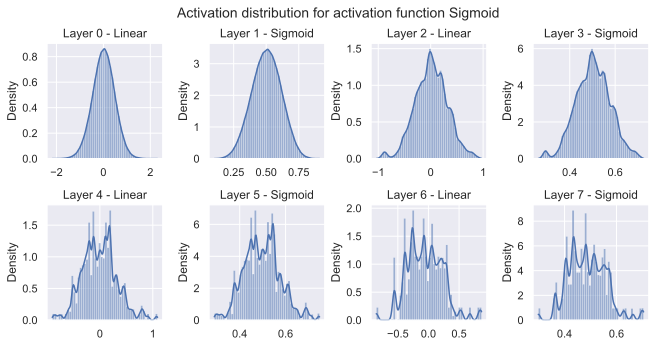

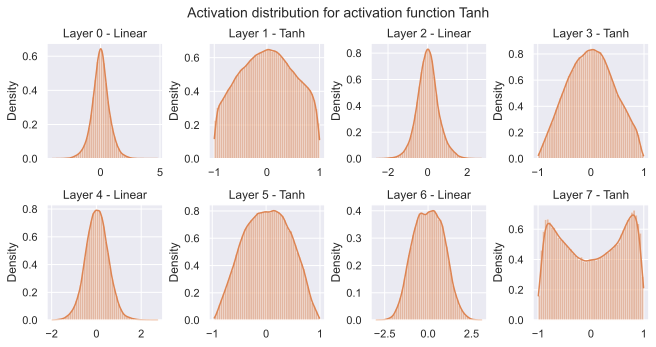

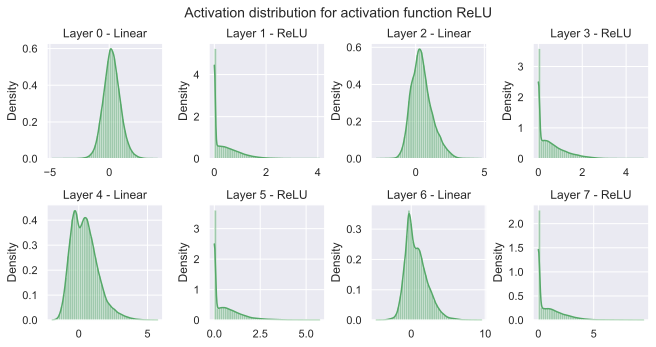

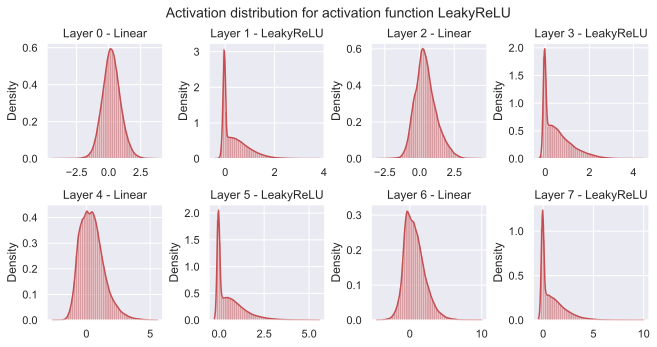

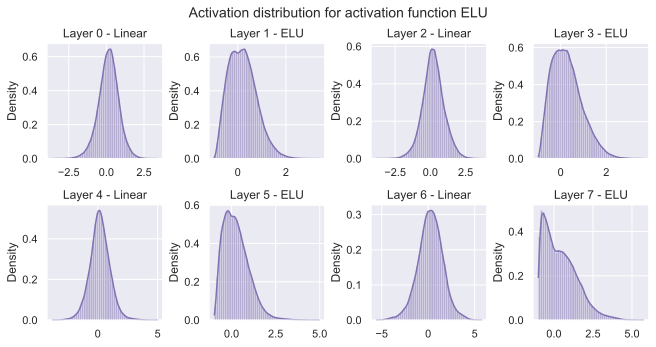

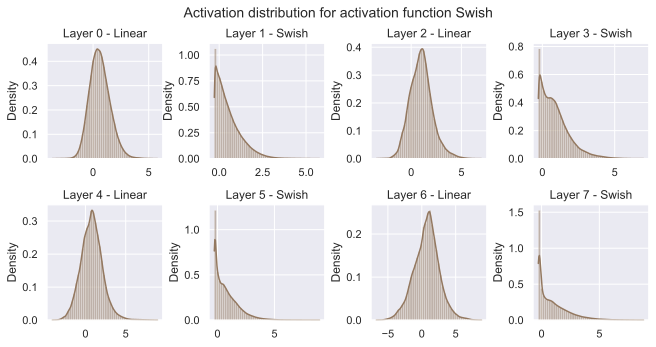

In [112]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_%s" % act_fn_name).to(device)
    visualize_activations(net_actfn, color="C%i" % i)

"As the model with sigmoid activation was not able to train properly, the activations are also less informative and all gathered around 0.5 (the activation at input 0).

The tanh shows a more diverse behavior. While for the input layer we experience a larger amount of neurons to be close to -1 and 1, where the gradients are close to zero, the activations in the two consecutive layers are closer to zero. This is probably because the input layers look for specific features in the input image, and the consecutive layers combine those together. The activations for the last layer are again more biased to the extreme points because the classification layer can be seen as a weighted average of those values (the gradients push the activations to those extremes).

The ReLU has a strong peak at 0, as we initially expected. The effect of having no gradients for negative values is that the network does not have a Gaussian-like distribution after the linear layers, but a longer tail towards the positive values. The LeakyReLU shows a very similar behavior while ELU follows again a more Gaussian-like distribution. The Swish activation seems to lie in between, although it is worth noting that Swish uses significantly higher values than other activation functions (up to 20).

As all activation functions show slightly different behavior although obtaining similar performance for our simple network, it becomes apparent that the selection of the "optimal" activation function really depends on many factors, and is not the same for all possible networks."

#### Dead Neurons in ReLU

In [122]:
def measure_number_dead_neurons(net):

    # For each neuron, we create a boolean variable initially set to 1. If it has an activation unequals 0 at any time,
    # we set this variable to 0. After running through the whole training set, only dead neurons will have a 1.
    neurons_dead = [
        torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool) for layer in net.layers[:-1] if isinstance(layer, nn.Linear)
    ] # Same shapes as hidden size in BaseNetwork

    net.eval()
    with torch.no_grad():
        for imgs, labels in tqdm(train_loader, leave=False): # Run through whole training set
            layer_index = 0
            imgs = imgs.to(device)
            imgs = imgs.view(imgs.size(0), -1)
            for layer in net.layers[:-1]:
                imgs = layer(imgs)
                if isinstance(layer, ActivationFunction):
                    # Are all activations == 0 in the batch, and we did not record the opposite in the last batches?
                    neurons_dead[layer_index] = torch.logical_and(neurons_dead[layer_index], (imgs == 0).all(dim=0))
                    layer_index += 1
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("Number of dead neurons:", number_neurons_dead)
    print("In percentage:", ", ".join([f"{(100.0 * num_dead / tens.shape[0]):4.2f}%" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]))


In [124]:
# Initialized network
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU()).to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 3, 10]
In percentage: 0.00%, 0.00%, 1.17%, 7.81%


In [126]:
# Trained network
net_relu = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_relu").to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 1, 13, 10]
In percentage: 0.00%, 0.39%, 5.08%, 7.81%


"it should be noted that dead neurons are especially problematic in the input layer. As the input does not change over epochs (the training set is kept as it is), training the network cannot turn those neurons back active. Still, the input data has usually a sufficiently high standard deviation to reduce the risk of dead neurons."

In [130]:
# Deep network
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU(), hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128]).to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 7, 27, 88, 60, 58, 61, 72, 56]
In percentage: 0.00%, 0.00%, 2.73%, 10.55%, 34.38%, 46.88%, 45.31%, 47.66%, 56.25%, 43.75%
